In [1]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 8.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=4da4b6908c46b8c95427361a1dc6059dcf4250992b2e23581aef4eccd5305ed3
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [2]:
!pip install Instrument

     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for Instrument: filename=instrument-0.6.0-cp36-none-any.whl size=10993 sha256=9915087beaa1067afb5f0048e029d420dd249bd37bafb8789607ae37fd7c7eec
  Stored in directory: /root/.cache/pip/wheels/3d/37/67/e371f926934582de6a6ff27130d4d17610661f35c7ed61ab2b
Successfully built Instrument


In [3]:
!pip install mido

In [4]:
from pretty_midi.constants import DRUM_MAP, INSTRUMENT_MAP, INSTRUMENT_CLASSES
import numpy as np
import re
from pretty_midi.utilities import key_number_to_key_name
from pretty_midi.containers import PitchBend
from pretty_midi.instrument import Instrument
import os
import pretty_midi
from scipy.io import wavfile 
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Change this part to locate the correct directory where dataset resides
use_colab = True

if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    DATA_DIRECTORY = "/content/gdrive/My Drive/data"
    

Mounted at /content/gdrive


In [6]:
n_x = 108
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

import os
from os import listdir
from os.path import isfile, join

# Modify this path to your own MAESTRO dataset
maestro_dir = '/content/gdrive/My Drive/data/maestro-v2.0.0'

data_dirs = []
#for year in ['2004', '2006', '2008', '2009', '2011', '2013', '2014', '2015', '2017', '2018']:
for year in ['2004']:
    data_dirs.append(maestro_dir + '/' + str(year))
#data_dirs.append(maestro_dir + '/test')
data_files = []
for data_dir in data_dirs:
    data_files += [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if 'midi' in f]

data_files.sort()

print('total midi files : ', len(data_files))

total midi files :  132


In [ ]:
max = 0
for midiFile in data_files:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    if (np.max(note_l) >= max):
      max = np.max(note_l)

n_x = max

In [8]:
X_list = []

for midiFile in data_files:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile, resolution = 396)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    #print(np.max(note_l))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

132
(1000, 108)
(1000, 108)
(1000, 108)


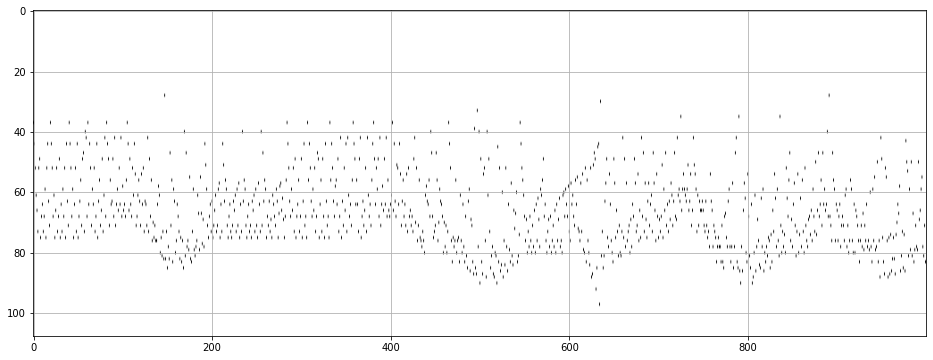

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

In [9]:
X_train_list = []
y_train_list = []

# CODE-RNN2-1
# --- START CODE HERE
X_train_list = [X_list[i][t:t+sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
y_train_list = [X_list[i][t+ sequence_length] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
# --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)
#y_train = np.reshape(y_train)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (129166, 20, 108)
y_train.shape: (129166, 108)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras import backend as K
import tensorflow as tf

In [12]:
model = Sequential()
model.add(LSTM(
        256,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
model.add(LSTM(256, return_sequences=True, recurrent_dropout=0.3,))
model.add(LSTM(256))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_x))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 256)           373760    
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)              

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=128)

Epoch 1/50
808/808 [==============================] - 105s 129ms/step - loss: 3.8606 - accuracy: 0.0744 - val_loss: 3.8449 - val_accuracy: 0.0595
Epoch 2/50
808/808 [==============================] - 103s 127ms/step - loss: 3.4782 - accuracy: 0.0875 - val_loss: 3.5186 - val_accuracy: 0.1004
Epoch 3/50
808/808 [==============================] - 102s 126ms/step - loss: 3.3892 - accuracy: 0.0940 - val_loss: 3.5010 - val_accuracy: 0.0919
Epoch 4/50
808/808 [==============================] - 103s 127ms/step - loss: 3.3368 - accuracy: 0.0995 - val_loss: 3.4033 - val_accuracy: 0.0972
Epoch 5/50
808/808 [==============================] - 103s 128ms/step - loss: 3.2923 - accuracy: 0.1088 - val_loss: 3.3411 - val_accuracy: 0.1167
Epoch 6/50
808/808 [==============================] - 102s 126ms/step - loss: 3.2567 - accuracy: 0.1176 - val_loss: 3.3202 - val_accuracy: 0.1195
Epoch 7/50
808/808 [==============================] - 102s 126ms/step - loss: 3.2207 - accuracy: 0.1249 - val_loss: 3.3205 -

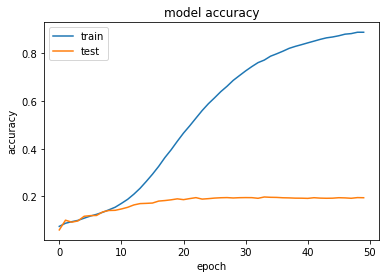

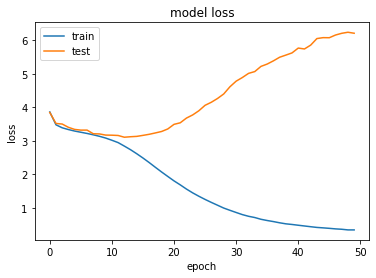

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)


note_l = []
prediction_l = []

# Generate T_y_generated notes
for note_index in range(T_y_generated):
    pred = model.predict(np.expand_dims(pattern[note_index:,:], 0))
    prediction_l.append(pred)
    note = np.argmax(pred, axis=1)
    note_l.append(note)
    note_ohe = np.zeros(108)
    note_ohe[note] = 1
    pattern = np.vstack((pattern, note_ohe))

110642
(20, 108)
(1, 20, 108)


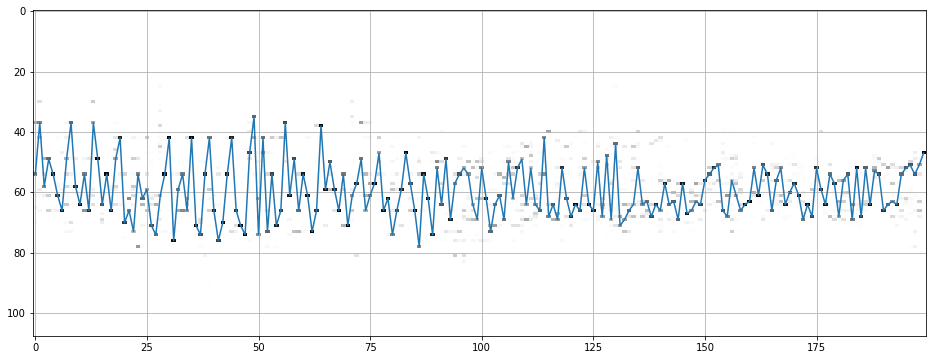

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)
time = 0
step = 0.2
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=120, pitch=note_number, start=time, end=time+step)
    piano.notes.append(myNote)
    time += step
new_midi_data.instruments.append(piano)
%matplotlib inline

#audio_data = new_midi_data.synthesize()
#IPython.display.Audio(audio_data, rate=44100)

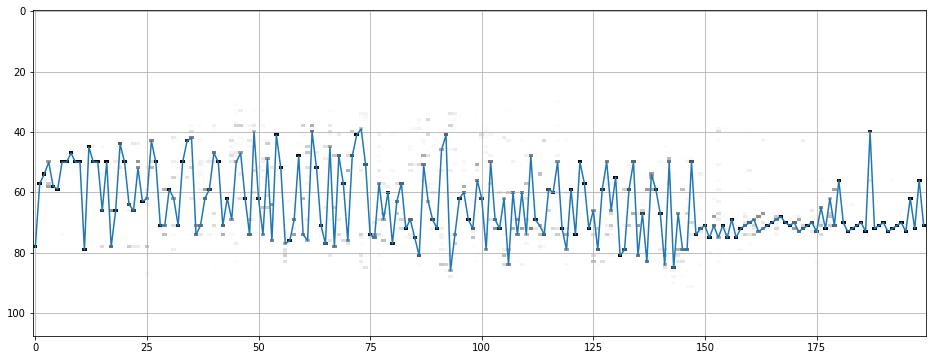

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
piano = pretty_midi.Instrument(program=piano_program)
time = 0
step = 0.2
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=120, pitch=note_number, start=time, end=time+step)
    piano.notes.append(myNote)
    time += step
new_midi_data.instruments.append(piano)
%matplotlib inline

#audio_data = new_midi_data.synthesize()
#IPython.display.Audio(audio_data, rate=44100)